In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\Users\jared\Dev\nn proj\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Processing

In [2]:
# Reading in dataset
df_train = pd.read_json('emo-train.json')
df_test = pd.read_json('emo-test.json')
df_train = df_train.drop(df_train[df_train['Label']=='others'].index)
df_test = df_test.drop(df_test[df_test['Label']=='others'].index)

In [3]:
# Encoding labels
label_encoder = LabelEncoder()
df_train['Label'] = label_encoder.fit_transform(df_train['Label'])
df_test['Label'] = label_encoder.transform(df_test['Label'])

In [4]:
# Tokenizing and encoding texts
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def encode_text(df, max_len=128):
    input_ids = []
    attention_masks = []

    for text in df['text']:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
        )
        
        input_ids.append(tf.squeeze(encoded_dict['input_ids'], axis=0))
        attention_masks.append(tf.squeeze(encoded_dict['attention_mask'], axis=0))

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    
    return input_ids, attention_masks

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

train_input_ids, train_attention_masks = encode_text(df_train)
val_input_ids, val_attention_masks = encode_text(df_val)
test_input_ids, test_attention_masks = encode_text(df_test)

val_labels = df_val['Label'].values

train_ds = tf.data.Dataset.from_tensor_slices(((train_input_ids, train_attention_masks), df_train.Label.values))
val_ds = tf.data.Dataset.from_tensor_slices(((val_input_ids, val_attention_masks), val_labels))
test_ds = tf.data.Dataset.from_tensor_slices(((test_input_ids, test_attention_masks), df_test.Label.values))

batch_size = 16
train_ds = train_ds.shuffle(len(df_train)).batch(batch_size=batch_size, drop_remainder=False)
val_ds = val_ds.batch(batch_size=batch_size, drop_remainder=False)
test_ds = test_ds.batch(batch_size=batch_size, drop_remainder=False)

In [5]:
# Computing class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['Label']),
    y=df_train['Label']
)
class_weight_dict = dict(enumerate(class_weights))

# BERT-CNN Model

In [6]:
def CNN_model():
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids') # Assuming a max length of 128
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

    # BERT base uncased encoder
    bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
    outputs = bert_encoder(input_ids, attention_mask=attention_mask)
    network_layer = outputs[0] 

    # CNN layers
    network_layer = tf.keras.layers.Conv1D(32, (2), activation='relu')(network_layer)
    network_layer = tf.keras.layers.GlobalMaxPool1D()(network_layer) 
    network_layer = tf.keras.layers.Dropout(0.5)(network_layer)
    network_layer = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(network_layer) 

    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=network_layer)

cnn_model = CNN_model()

from official.nlp import optimization

epochs_count = 10
steps_each_epoch = tf.data.experimental.cardinality(train_ds).numpy()
number_of_training_steps = steps_each_epoch * epochs_count
number_of_warmup_steps = int(0.1*number_of_training_steps)
init_lr = 3e-5

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=number_of_training_steps,
                                          num_warmup_steps=number_of_warmup_steps,
                                          optimizer_type='adamw')

cnn_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print(f'Training BERT CNN model...')
cnn_history = cnn_model.fit(x=train_ds,
                            validation_data=val_ds,
                            epochs=epochs_count,
                            class_weight=class_weight_dict,
                            callbacks=[early_stop])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Training BERT CNN model...
Epoch 1/10


761/761 [==============================] - 191s 229ms/step - loss: 0.7245 - accuracy: 0.7288 - val_loss: 0.3038 - val_accuracy: 0.9211
Epoch 2/10
761/761 [==============================] - 174s 228ms/step - loss: 0.2322 - accuracy: 0.9459 - val_loss: 0.1682 - val_accuracy: 0.9563
Epoch 3/10
761/761 [==============================] - 172s 226ms/step - loss: 0.1484 - accuracy: 0.9679 - val_loss: 0.2365 - val_accuracy: 0.9550
Epoch 4/10
761/761 [==============================] - 173s 228ms/step - loss: 0.0975 - accuracy: 0.9800 - val_loss: 0.3314 - val_accuracy: 0.9514
Epoch 5/10
761/761 [==============================] - 175s 230ms/step - loss: 0.0651 - accuracy: 0.9875 - val_loss: 0.3544 - val_accuracy: 0.9563


In [7]:
# Predicting on test dataset
predictions = cnn_model.predict(test_ds)
y_pred = np.argmax(predictions, axis=-1)

print(classification_report(df_test.Label.values, y_pred))

52/52 [==============================] - 6s 71ms/step
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       298
           1       0.96      0.94      0.95       284
           2       0.91      0.90      0.91       250

    accuracy                           0.93       832
   macro avg       0.93      0.93      0.93       832
weighted avg       0.93      0.93      0.93       832



In [8]:
cnn_model.save('saved_models/emo')

INFO:tensorflow:Assets written to: saved_models/emo\assets


INFO:tensorflow:Assets written to: saved_models/emo\assets


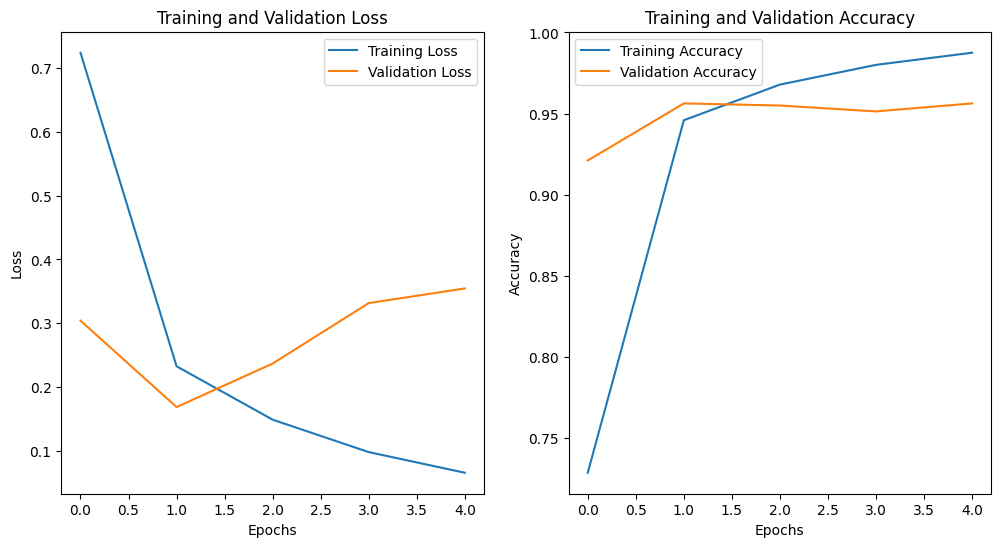

In [9]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()